In [4]:
options(warn=-1)

library(TSCAN)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
# utility function for setting plot dimensions
set_plot_dimensions = function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)}

In [3]:
## Using Imported PCA Representation
#-----------------------------------------------------------------
## extracting coordinates and cluster annotations
# PCA_coordinates = read.csv(file = '/scratch/PCA_coordinates.csv')
# rownames(PCA_coordinates) = PCA_coordinates[,'X']
# PCA_coordinates = PCA_coordinates[,2:ncol(PCA_coordinates)]
# clusterid = as.numeric(as.factor(PCA_coordinates['cluster',]))
# PCA_coordinates = PCA_coordinates[1:nrow(PCA_coordinates)-1,]
# names(clusterid) = colnames(PCA_coordinates)
## the reduce=F argument is crucial, without it the function performs SVD again
# PCA_cluster = exprmclust(PCA_coordinates,cluster=clusterid,reduce=F)
# set_plot_dimensions(20,20)
# plotmclust(PCA_cluster)+scale_shape_manual(values=c(1:50))
## mapping cells onto tree stem to generate pseudotime ordering
# PCA_cluster_order = TSCANorder(PCA_cluster)
# PCA_coordinates = read.csv(file = '/scratch/PCA_coordinates.csv')
# PCA_states = unique(PCA_cluster_order[,'State'])
## get the trajectory for clusters
# cat('Pseudotime ordering using PCA coordinates in UMAP cluster number: ' )
# for (state in PCA_states){
#     if (state!= PCA_states[length(PCA_states)]){
#         cat(paste(PCA_coordinates[nrow(PCA_coordinates),][,rownames(PCA_cluster_order[PCA_cluster_order['State']==state,])[1]],'--> '))
#         }
#     else{
#         cat(PCA_coordinates[nrow(PCA_coordinates),][,rownames(PCA_cluster_order[PCA_cluster_order['State']==state,])[1]])
#     }
# }

## Using Imported UMAP Coordinates

In [25]:
UMAP_coordinates = read.csv('/scratch/memory_UMAP_coordinates.csv',row.names=1)

In [26]:
UMAP_coordinates

,ACGAGCCCAGGATTGG.1.0,AGTGGGACACCTCGTT.1.0,CACAGGCAGCTAGGCA.1.0,CCTCTGACAGACAGGT.1.0,CGACCTTAGTCCGTAT.1.0,CGATTGACACAGGCCT.1.0,CGGACGTGTAGTGAAT.1.0,CTGATAGGTGCGCTTG.1.0,GACGTGCAGTGGGCTA.1.0,GCCAAATCATTACGAC.1.0,...,TTTGGTTGTATGGTTC.1.22,TTTGGTTGTCCGAATT.1.22,TTTGTCAAGAGTCTGG.1.22,TTTGTCACAGGAATCG.1.22,TTTGTCACATCTATGG.1.22,TTTGTCACATGAACCT.1.22,TTTGTCATCAACACCA.1.22,TTTGTCATCACCACCT.1.22,TTTGTCATCGGCGGTT.1.22,TTTGTCATCTTGAGGT.1.22
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UMAP_0,7.695529,11.278434,11.850173,8.211012,10.858838,3.537054,9.642598,11.191298,8.430800,8.947874,...,8.091536,7.880095,6.526632,7.637938,8.230060,6.575059,6.324291,7.387442,6.487526,11.340755
UMAP_1,10.069707,3.386112,7.127515,6.823201,3.803485,5.462510,4.957741,7.513226,6.749991,5.639731,...,5.851480,7.711942,6.642684,8.198316,6.919378,8.365280,9.200327,9.293725,9.623561,7.589211
cluster,1.000000,5.000000,2.000000,3.000000,5.000000,18.000000,18.000000,2.000000,3.000000,18.000000,...,9.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,2.000000


In [27]:
# casting the cluster annotation into natural number representing "states" as referred to by TSCAN
# this is necessar for TSCAN to work
clusterid = as.numeric(as.factor(UMAP_coordinates['cluster',]))
UMAP_coordinates = UMAP_coordinates[1:2,]
names(clusterid) = colnames(UMAP_coordinates)
# the reduce=F argument is crucial, without it the function performs SVD again
UMAP_cluster = exprmclust(UMAP_coordinates, cluster=clusterid, reduce=F)

In [28]:
UMAP_cluster = exprmclust(UMAP_coordinates, cluster=clusterid, reduce=F)

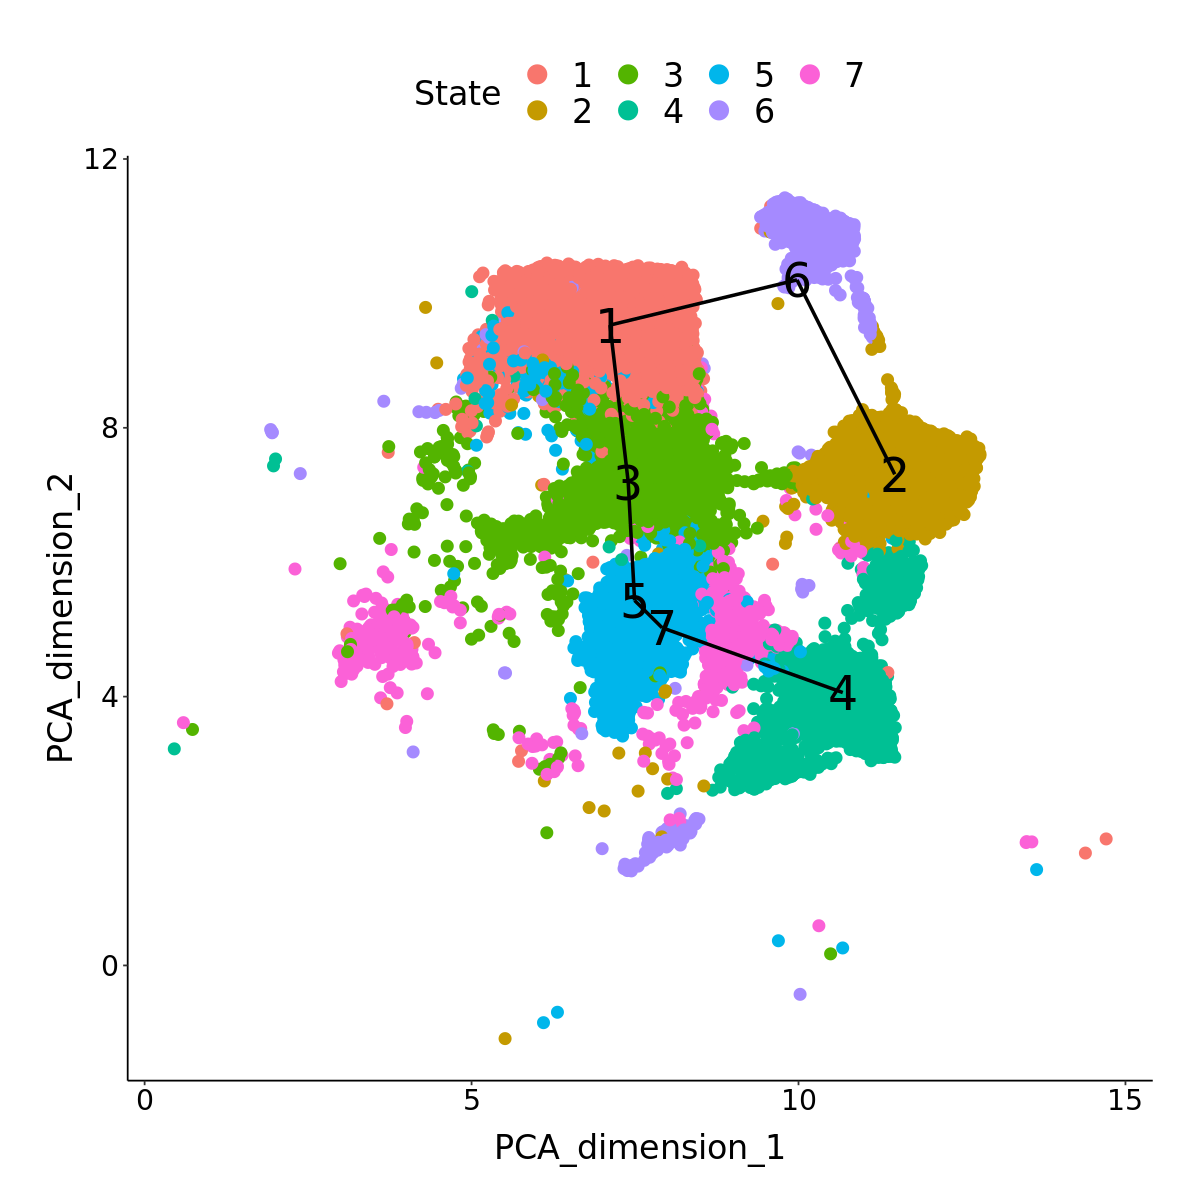

In [29]:
set_plot_dimensions(10,10)
plotmclust(UMAP_cluster)+scale_shape_manual(values=c(0:23))

#### Infer all possible trajectories

In [174]:
# infer trajectories with TSCANorder, listbranch=TRUE finds all possible trajectories
multibranch_pseudotime_order = TSCANorder(UMAP_cluster, listbranch=TRUE)

In [175]:
# put all trajectories (as strings) in all_trajectories
all_trajectories = attributes(multibranch_pseudotime_order)$names

#### Export all possible trajectories

In [176]:
all_trajectories_file = '/scratch/all_trajectories.txt'
if (file.exists(all_trajectories_file)) {
  #Delete file if it exists
  file.remove(all_trajectories_file)
}
# extract the cluster ordering from each trajectory
for (trajectory in all_trajectories){
    order_in_original_number = c()
    state_order = regmatches(trajectory, gregexpr("[[:digit:]]+", trajectory))
    for (state in unlist(state_order)){
        #print(as.numeric(state))
        order_in_TSCAN_state = multibranch_pseudotime_order[[trajectory]]
        order_in_original_number = c(order_in_original_number, UMAP_coordinates[nrow(UMAP_coordinates),][,rownames(order_in_TSCAN_state[order_in_TSCAN_state['State']==as.numeric(state),])[1]])
    }
    #print(paste(unlist(order_in_original_number),collapse='->'))
    write.table(paste(unlist(order_in_original_number),collapse='->'),file="/scratch/all_trajectories.txt", append=TRUE,col.names=FALSE,row.names=FALSE)
}

#### Looking at the backbone

In [36]:
UMAP_cluster_order = TSCANorder(UMAP_cluster)

In [37]:
UMAP_states = unique(UMAP_cluster_order[, 'State'])

In [38]:
UMAP_coordinates = read.csv('/scratch/memory_UMAP_coordinates.csv', row.names=1)

In [39]:
cluster_pseudotime_order = c()

cat('Pseudotime ordering using UMAP coordinates in UMAP cluster number: ' )
for (state in UMAP_states){
    if (state!= UMAP_states[length(UMAP_states)]){
        cat(paste(UMAP_coordinates[nrow(UMAP_coordinates),][,rownames(UMAP_cluster_order[UMAP_cluster_order['State']==state,])[1]],'--> '))
        cluster_pseudotime_order = c(cluster_pseudotime_order, UMAP_coordinates[nrow(UMAP_coordinates),][,rownames(UMAP_cluster_order[UMAP_cluster_order['State']==state,])[1]])
        }
    else{
        cat(UMAP_coordinates[nrow(UMAP_coordinates),][,rownames(UMAP_cluster_order[UMAP_cluster_order['State']==state,])[1]])
        cluster_pseudotime_order = c(cluster_pseudotime_order, UMAP_coordinates[nrow(UMAP_coordinates),][,rownames(UMAP_cluster_order[UMAP_cluster_order['State']==state,])[1]])
    }
}

cat('\n')
cat('We might need to reverse the order for interpretation.')

Pseudotime ordering using UMAP coordinates in UMAP cluster number: 2 --> 14 --> 1 --> 3 --> 9 --> 18 --> 5
We might need to reverse the order for interpretation.

In [40]:
cluster_pseudotime_order

[1]  2 14  1  3  9 18  5

## Differential Expression along Trajectory

In [41]:
#### Differential Expression along PCA defined trajectory
expression_matrix = read.csv('/scratch/memory_trajectory_expression_data/exprMatrix.tsv',sep='\t',row.names=1)
#PCA_diffval = difftest(expression_matrix, PCA_cluster_order)
#row.names(PCA_diffval)[PCA_diffval$qval < 0.05]

#### Differential Expression along UMAP defined trajectory

In [42]:
expression_matrix = read.csv('/scratch/memory_trajectory_expression_data/exprMatrix.tsv',sep='\t',row.names=1)
UMAP_diffval = difftest(expression_matrix, UMAP_cluster_order)

In [43]:
diff_exp_genes = row.names(UMAP_diffval)[UMAP_diffval$qval < 0.05]

In [44]:
# cast both the gene list and trajecotory into a dataframe for exporting
genes_and_pseudotime = list()
genes_and_pseudotime[['genes']] = diff_exp_genes
genes_and_pseudotime[['order']] = cluster_pseudotime_order

In [45]:
tmp = plyr::ldply(genes_and_pseudotime, rbind)
tmp = t(tmp)
colnames(tmp) = tmp[1,]
genes_and_pseudotime = tmp[-1,]

In [46]:
write.table(genes_and_pseudotime,file="/scratch/memory_genes_and_peudotime.txt",row.names= FALSE)